## **Getting new Object Detection data**
Getting images into a format such that you can train an object detection model is one of the more difficult things you might try to tackle. The following notebook details how you might do this. 


In [1]:
import turicreate as tc
import pandas as pd
import json
import os
import math

# imaging modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

Below we define a function that translates "bounding boxes" from the open source dataset we are using for this example into a format that TuriCreate can work with.

The reason we must perform this transformation is that many "annotations" on open source image data sets will treat the upper left hand corner of the image as 0,0 but TuriCreate treats the center of the image as 0,0. To read more about this discussion, checkout this [GitHub issue](https://github.com/apple/turicreate/issues/1285). 


In [2]:
# helper function that will build our bounding boxes in a way that TuriCreate can work with
def build_annotations(row):
    ret = {'coordinates':
                  {'x' : row.bbox[0] + row.bbox[2] / 2, # if using a different fre
                   'y'  : row.bbox[1] + row.bbox[3] / 2,
                   'width': row.bbox[2],
                   'height': row.bbox[3]},
                  'label': row.label}
    return ret

## **Load the Data**
The next 3 cells:
- load the data and annotations
- translate some of the fields to get the labels and image paths
- build a dataframe to join to the images we load directly into a Turi Create SFrame

The data in this example comes from the open source **COCO dataset** that can be downloaded [here](http://cocodataset.org/#download). Download the following from this page:
- [2017 Val images](http://images.cocodataset.org/zips/val2017.zip)
- [2017 Train/Val annotations](http://images.cocodataset.org/annotations/annotations_trainval2017.zip)

Once you've downloaded them, move them to your working directory, and unzip the compressed folders.

You should now have 2 directories:
- `annotations/`
- `val2017/`

In [3]:
# load the annotations (bounding boxes coordinates for our images)
with open("./annotations/instances_val2017.json", "r") as infile:
    annotations = json.load(infile)

In [4]:
category_map = {}
for c in annotations['categories']:
    category_map[c['id']] = c['name']

In [5]:
# build a category map to convert integers to names
category_map = {} 
for c in annotations['categories']:
    category_map[c['id']] = c['name']

# pull out the bounding boxes for each of the annotations 
bboxes = []
for a in annotations['annotations']:
    bboxes.append({'id': str(a['image_id']).zfill(12),
                   'bbox' : a['bbox'],
                   'category': a['category_id']})


# pull out the image information from the annotations
image_ids = []
for i in annotations['images']:
    image_ids.append({'id' : str(i['id']).zfill(12),
                      'file_name' : i['file_name'],
                     'height': i['height'],
                     'width': i['width']})
    
# build dataframes for the bboxes and image_ids
bboxes_df = pd.DataFrame.from_records(bboxes)
image_ids_df = pd.DataFrame.from_records(image_ids)

# create a master dataframe with the bboxes and image ids
image_meta = pd.merge(image_ids_df, bboxes_df, on = 'id')

# clean up the columns of the master dataframe
image_meta['label'] = image_meta['category'].apply(lambda x: category_map[x])
image_meta['bbox'] = image_meta.apply(lambda x: build_annotations(x), axis = 1)
image_meta['name'] = image_meta['file_name'].apply(lambda x: str(x).zfill(12))

# select the columns we need
sf_masks = tc.SFrame(image_meta[['name', 'label', 'bbox']])

## **Copy Turi Create's code to get data in the right format**

Making use of Turi Create's `sframe.join` was important in getting this to work. We highly recommend you use this workflow as opposed to building the image and annotations rows yourself and then converting to an SFrame.

In [6]:
# Combine bounding boxes of the same 'name' into lists
sf_annotations = sf_masks.groupby('name',
                                 {'annotations': tc.aggregate.CONCAT('bbox')})
sf_annotations['name'] = sf_annotations['name'].apply(lambda x: x.replace(".jpg", ""))

raw_sf = tc.image_analysis.load_images('val2017', recursive = True, random_order = True)
info = raw_sf[
    'path'].apply(lambda path: os.path.basename(path).split('.')[:2])

# Rename columns to 'name' and 'type'
info = info.unpack().rename({'X.0': 'name', 'X.1': 'type'})

# Add to our main SFrame
raw_sf = raw_sf.add_columns(info)

sf = raw_sf.join(sf_annotations, on='name', how='left')

# The LEFT join fills missing matches with None, so we replace these with empty
# lists instead using fillna.
sf['annotations'] = sf['annotations'].fillna([])

# Remove unnecessary columns
del sf['type']


In [7]:
sf_small = sf[0:40] # create smaller SFrame because rendering all images takes a while.

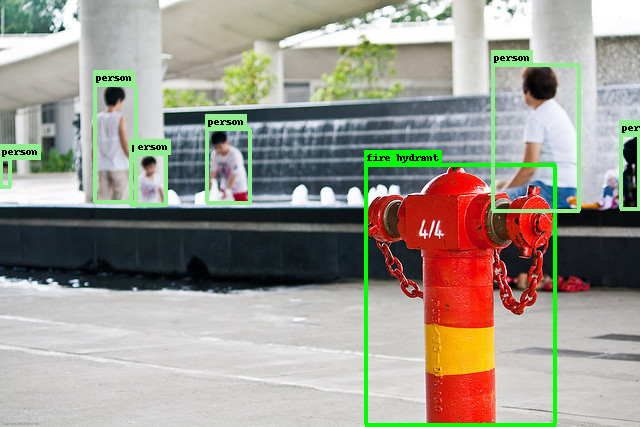

In [8]:
# show an image and its bounding boxes
which_image_to_plot = 28 # feel free to change this and look at other images (note sf_small just has the first 40 images)
tc.object_detector.util.draw_bounding_boxes(sf_small['image'], sf_small['annotations'])[which_image_to_plot].show()